<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/nn-03-regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization Techniques

_Challenge: We know we have a linear problem, but neural networks predict a very complex decision boundary. This is called overfitting. Techniques to fight overfitting are called regularization._


There are good reasons to believe that there is an implicit form of regularization in gradient descent without having to take further action https://arxiv.org/pdf/2009.11162.pdf

Expicit techniques to improve on that generalization
0. increased batch size
1. simplify model
1. early stopping
1. use simple SGD optimizer
1. add classic L1/L2 regularization
1. dropout and batch normalization
1. use selu activation and alpha dropout


# Hands-On: Choose one approach and try it out for yourself  

* run the code and try to understand the approach as much as possible
* can you improve the results of the given solution?
* choose a second one and compare the two in respect to
  * how comprehensible is the approach
  * how effectively does it fight overfitting
  * what story the decision boundary plot tells

_Bear in mind: this is an experimental science, intuitions are vage (and often turn out to be plain wrong in retrospect)_

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
tf.random.set_seed(42)

In [ ]:
!nvidia-smi

Sun Nov  1 08:39:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# used to find good parameters for classic l1/l2
!pip install -q keras-tuner

     |████████████████████████████████| 61kB 3.8MB/s 


In [ ]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

     |████████████████████████████████| 71kB 5.0MB/s 


In [ ]:
from lrcurve import KerasLearningCurve

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [ ]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

cmap = ListedColormap(['#FF6666', '#6666FF'])

font_size=15
title_font_size=25

def meshGrid(x_data, y_data):
    h = .05  # step size in the mesh
#     x_min, x_max = -0.1, 1.1
#     y_min, y_max = -0.1, 1.1

    x_min, x_max = x_data.min() - .1, x_data.max() + .1
    y_min, y_max = y_data.min() - .1, y_data.max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   ax=None, marker_size=100
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      _, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='o', edgecolors='k', s=classes*marker_size)
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='^', edgecolors='k', s=~classes.astype(bool)*marker_size)

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    return ax


# binary classification - We only have two categories (0/1 or red/blue)

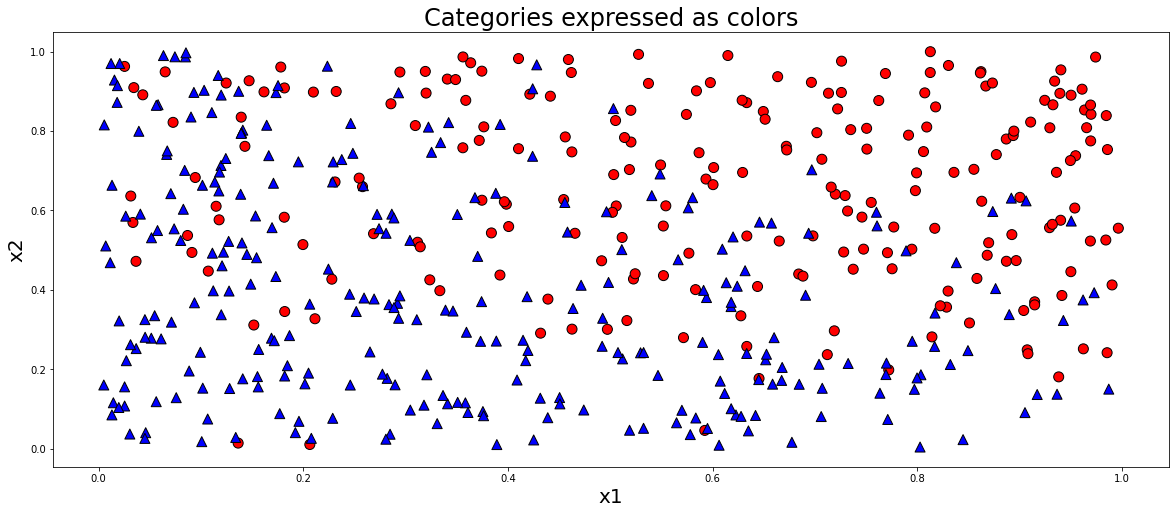

In [ ]:
#@title Configure our example { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 500 #@param {type:"slider", min:1, max:5000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.4 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = np.random.normal(0, noise_level, n)
y_bool = X[:, 1] > m*X[:, 0]+b + noise
y = y_bool.astype(int)

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

size=100

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, marker='o', edgecolors='k', s=y*size);
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, marker='^', edgecolors='k', s=~y_bool*size);

### We have two dimensions as input

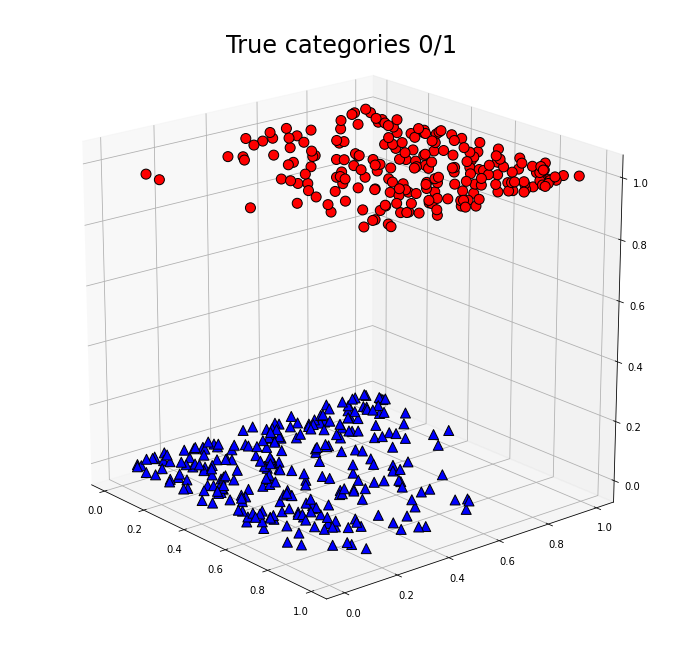

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('True categories 0/1')

# we can have the probability encoded in shade of color
ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=plt.cm.bwr,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y*size)

ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=plt.cm.bwr,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_bool*size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=20, azim=-40)

# Splitting data

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/img/generalization.jpg?raw=1'>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

# The issue: Overfitting

In [ ]:
%%time 
 
EPOCHS=1000    

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense    

model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 50.5 s, sys: 5.81 s, total: 56.3 s
Wall time: 52.5 s


### Loss and Accuracy diverge over time

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.35133686661720276, 0.8349999785423279)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.5240820050239563, 0.7300000190734863)

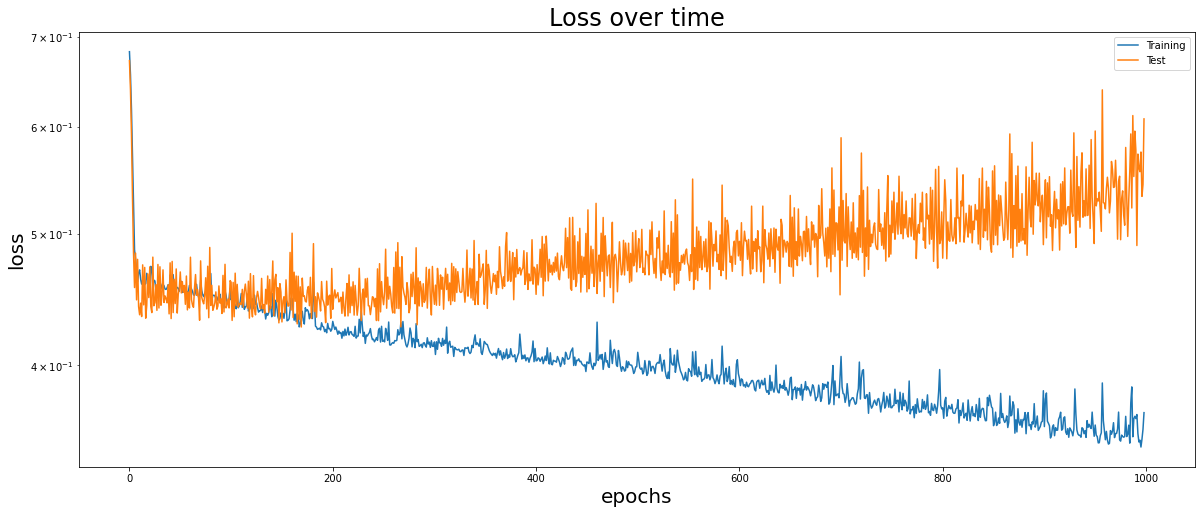

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

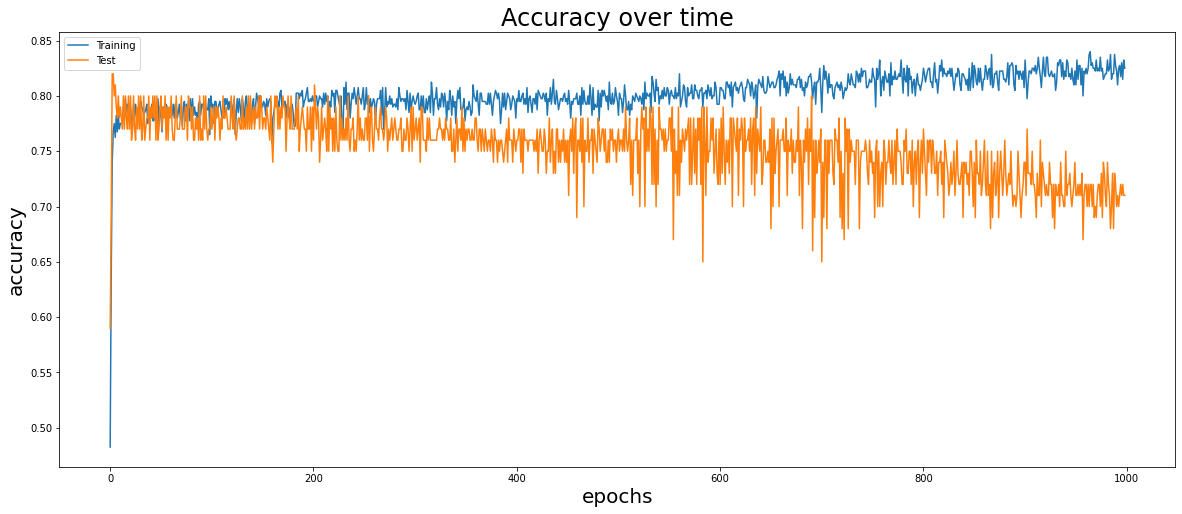

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

### Even if they don't diverge a decision boundary plot might reveal a deeper problem

Instructions for updating:
Please use `model.predict()` instead.


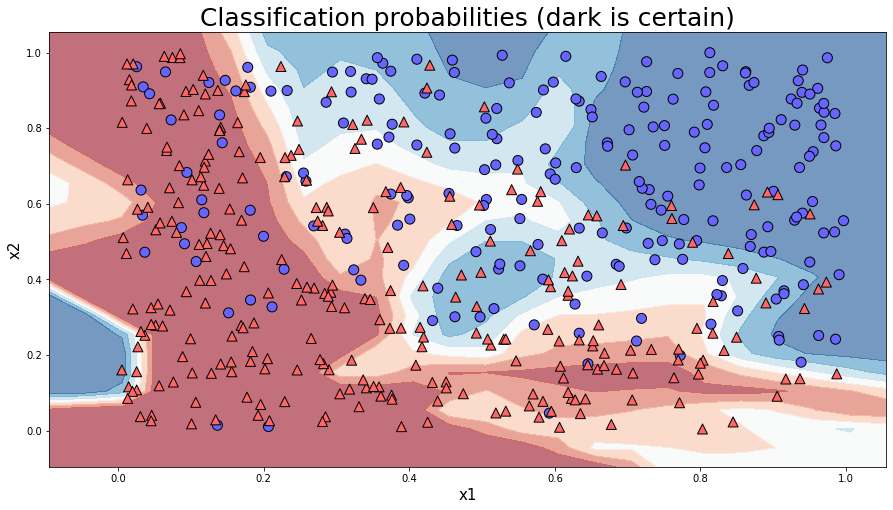

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach 0: Large Batch Size

***intuition: do not allow model to overfit on single data points, because update will be for all data points at the same time***

often doesn't work too well and sometimes is not feasiable because of limited memory on GPU

side effect can be shorter training time

In [ ]:
%%time 

EPOCHS=1000
# BATCH_SIZE=32 # default
BATCH_SIZE=500 # basically all the data

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 18.5 s, sys: 2.38 s, total: 20.9 s
Wall time: 20.4 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.3706057667732239, 0.8174999952316284)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.48776406049728394, 0.7699999809265137)

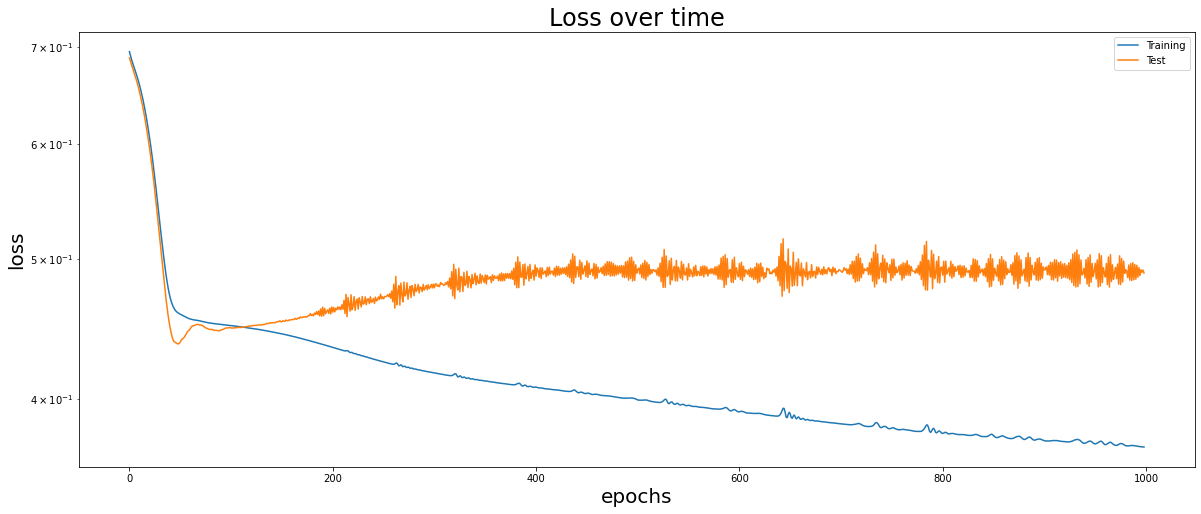

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

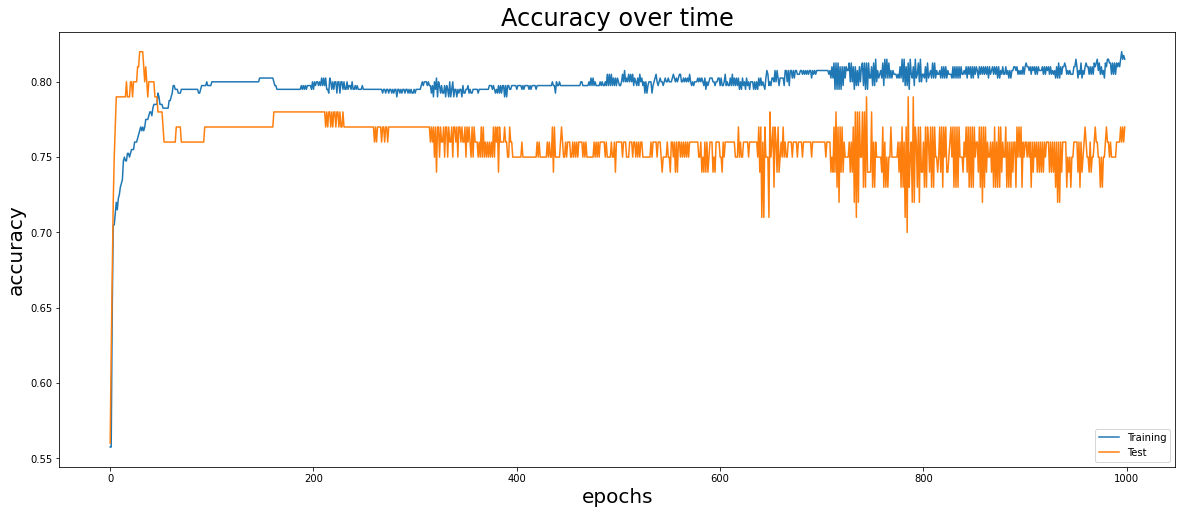

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

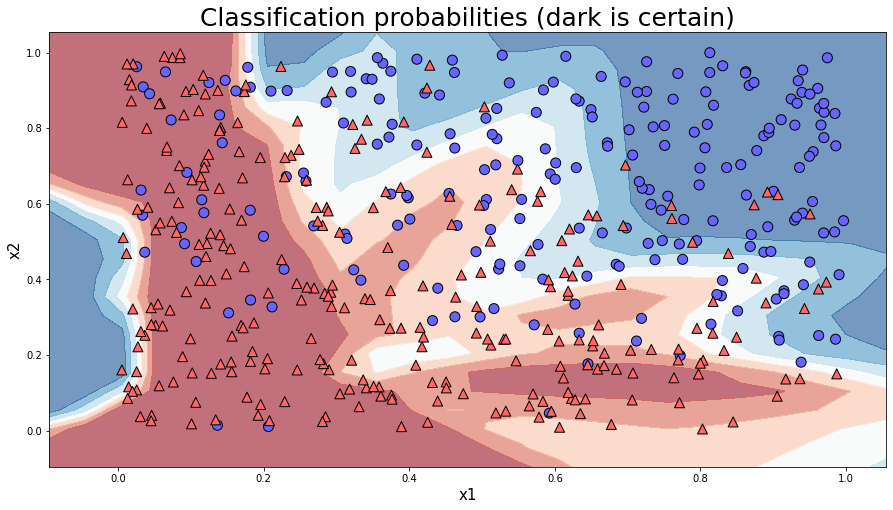

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach I: Simple model

***intuition: restrict model by simplicity, do not give it enough capacity to overfit***

might instead cause underfitting

to become really good might need information about true model


In [ ]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
learning_rate=1e-3 #DEFAULT
# learning_rate=1e-2

from tensorflow.keras.layers import Dense    
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)     
    
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 45.1 s, sys: 5.03 s, total: 50.1 s
Wall time: 40.7 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.47456222772598267, 0.7900000214576721)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4900873601436615, 0.800000011920929)

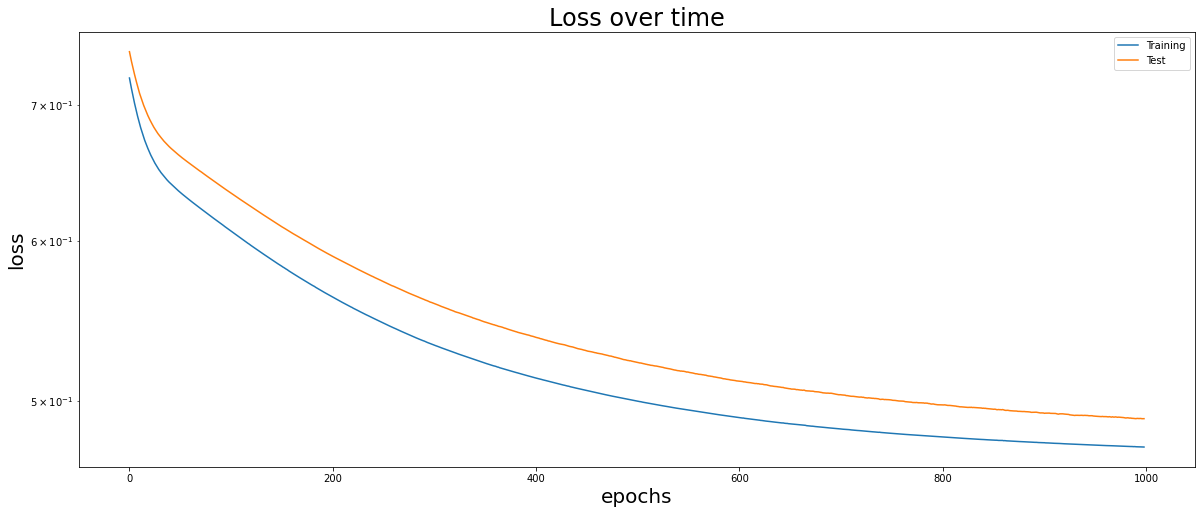

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

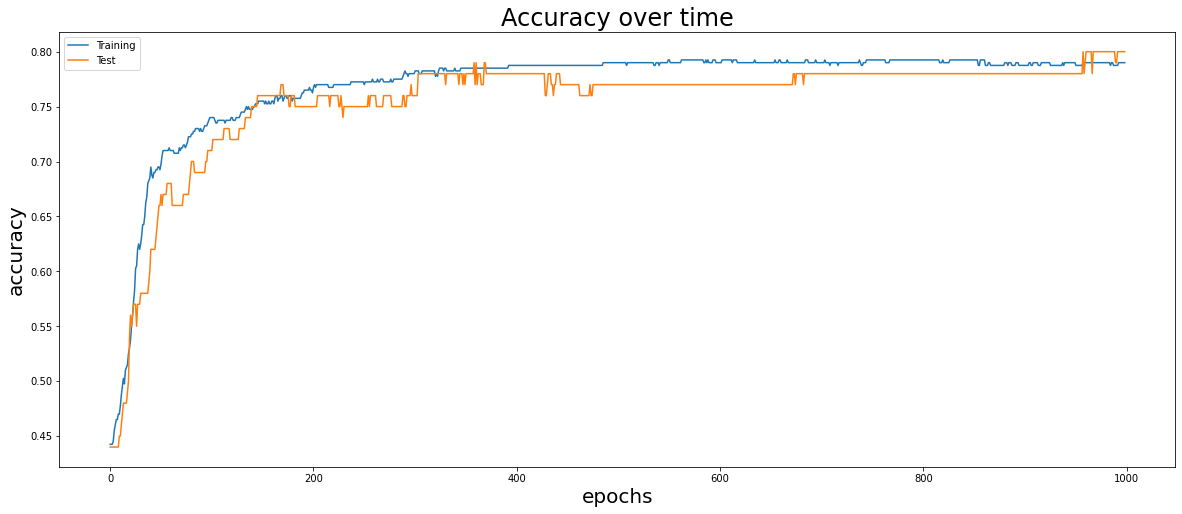

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

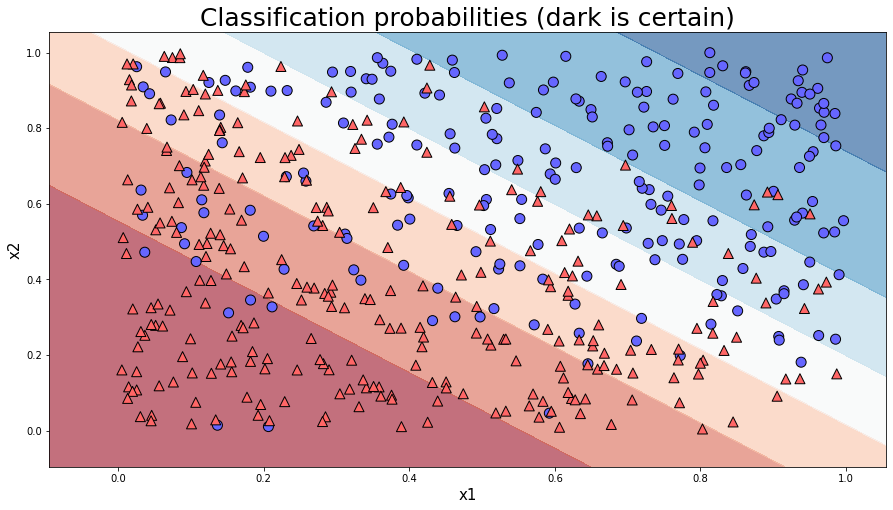

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach II: Early Stopping

***intuition: stop training once the model starts to overfit***

will not work if the model starts overfitting right from the start

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
learning_rate=1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)     

PATIENCE = 10
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    verbose=0)

CPU times: user 1.94 s, sys: 154 ms, total: 2.09 s
Wall time: 1.84 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4546085000038147, 0.7875000238418579)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4413905739784241, 0.7699999809265137)

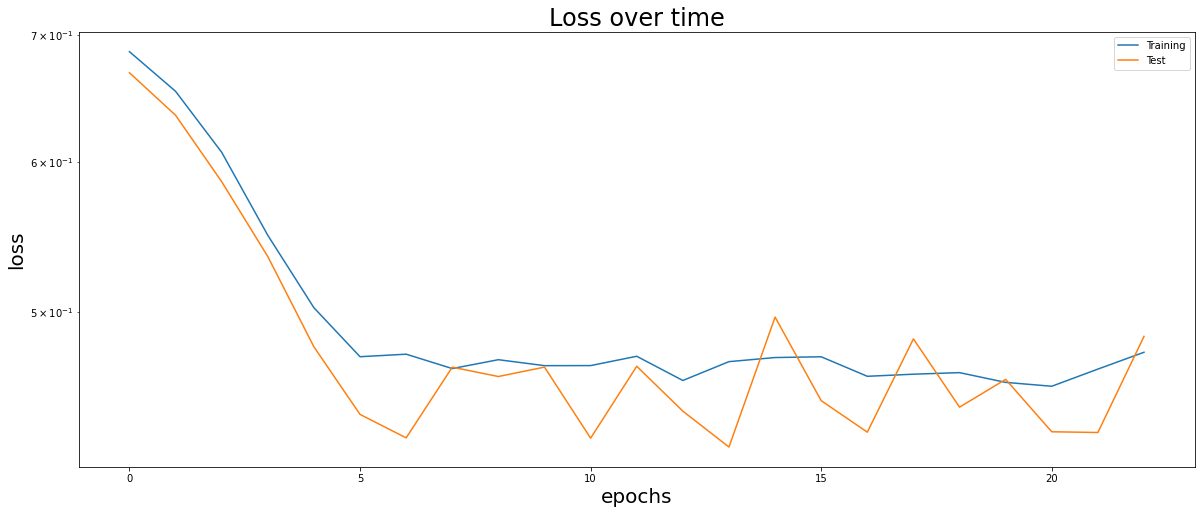

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

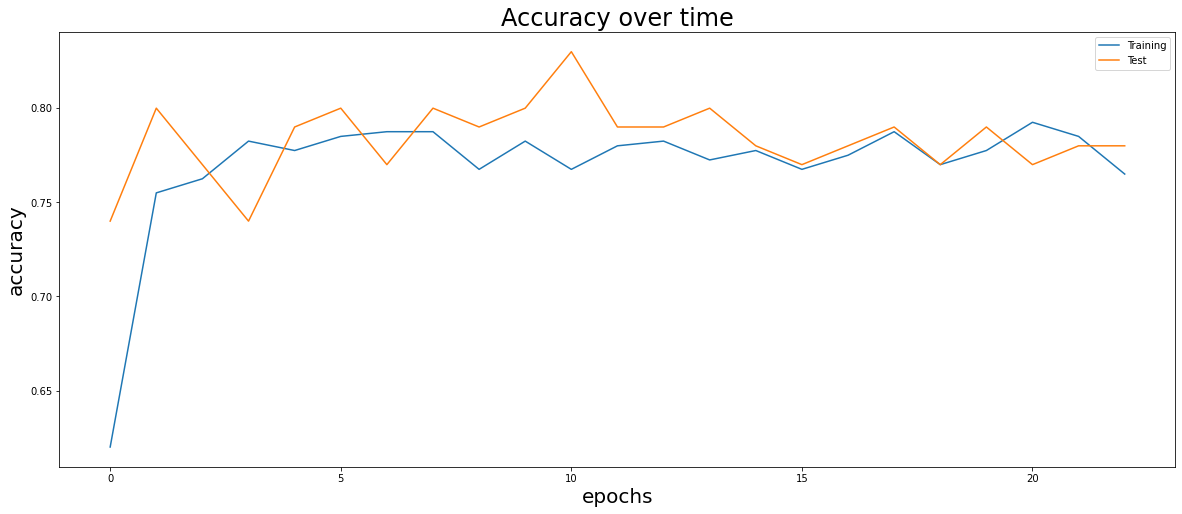

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

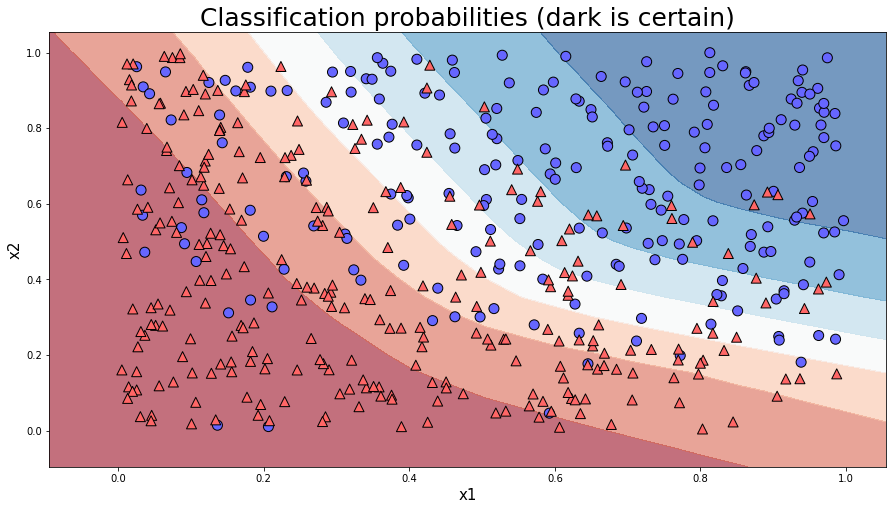

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach III: Use SGD

***intuition: Pure SGD just is not smart enough to find a highly specific solution***

still takes a lot of time

In [ ]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
# learning_rate=1e-3
learning_rate=1e-2 #DEFAULT

from tensorflow.keras.layers import Dense    
    
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)     
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 48.5 s, sys: 5.21 s, total: 53.7 s
Wall time: 44.1 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4510420858860016, 0.7900000214576721)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4483417570590973, 0.7599999904632568)

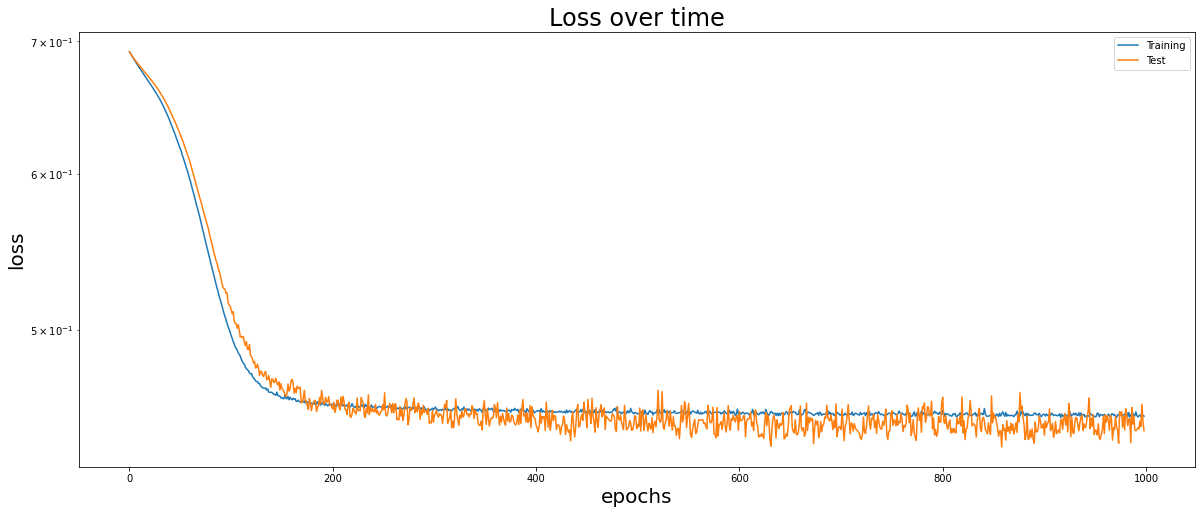

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

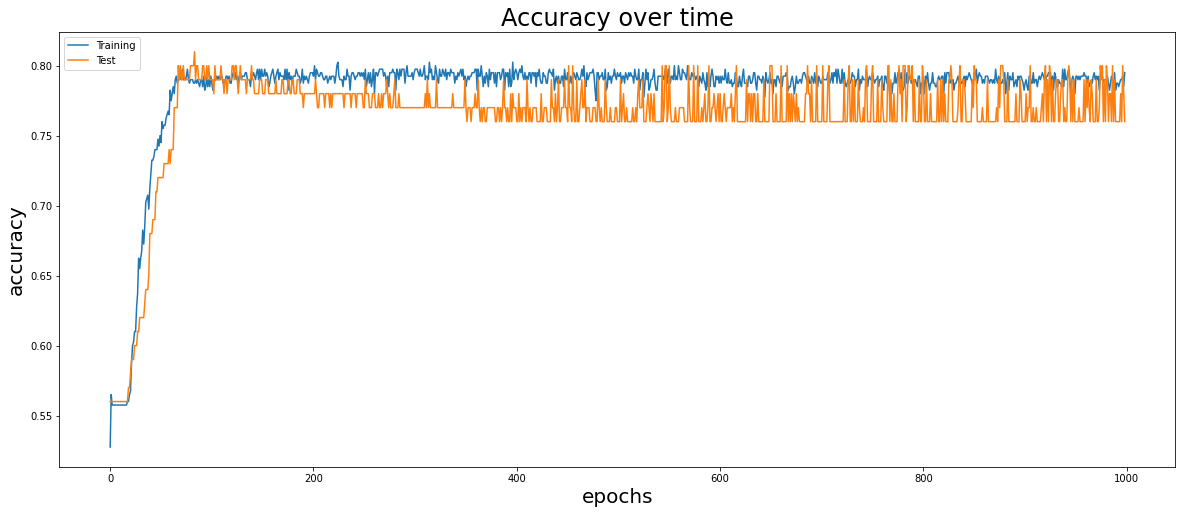

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

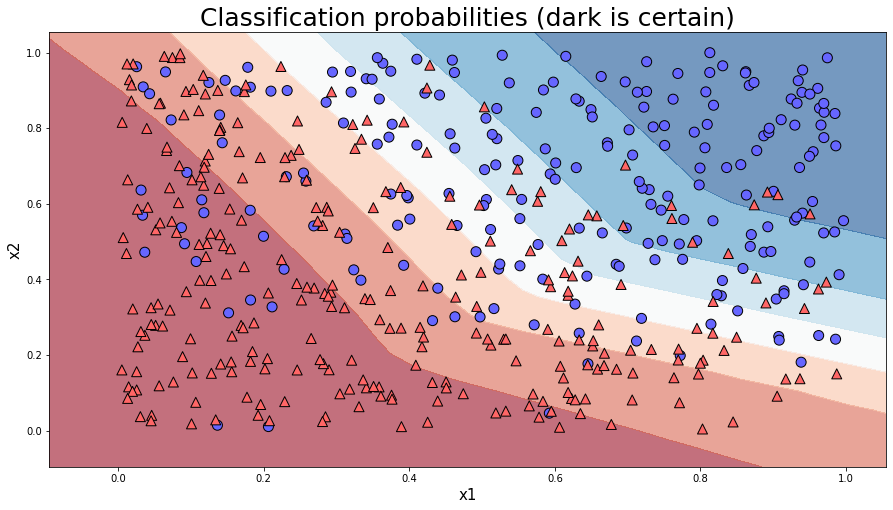

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach IV: classic L1/L2 regularization

***intuition: add a regularization term to the loss to restrict size of model parameters***

* l1 will bring down parameters to zero that are not so important, resulting in a sparse model
* l2 keeps parameters in a reasonable size

Finding right lambda parameters (factor for regularization term) for l1 and l2 is needs experimentation

### Sparsity and the L1 Norm

<img src='https://djcordhose.github.io/ml-workshop/img/sparsity-and-l1.png'>

https://youtu.be/76B5cMEZA4Y

In [ ]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

## L1 plus early stopping

lambda determined by manual experiment

In [ ]:
%%time 
 
EPOCHS=1000

l1 = .03
l2 = .0

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense
    
model = tf.keras.Sequential()
model.add(Dense(units=100, 
                input_dim=2, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    verbose=0)

CPU times: user 20 s, sys: 2.39 s, total: 22.3 s
Wall time: 17.1 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.46130141615867615, 0.800000011920929)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4964120090007782, 0.7900000214576721)

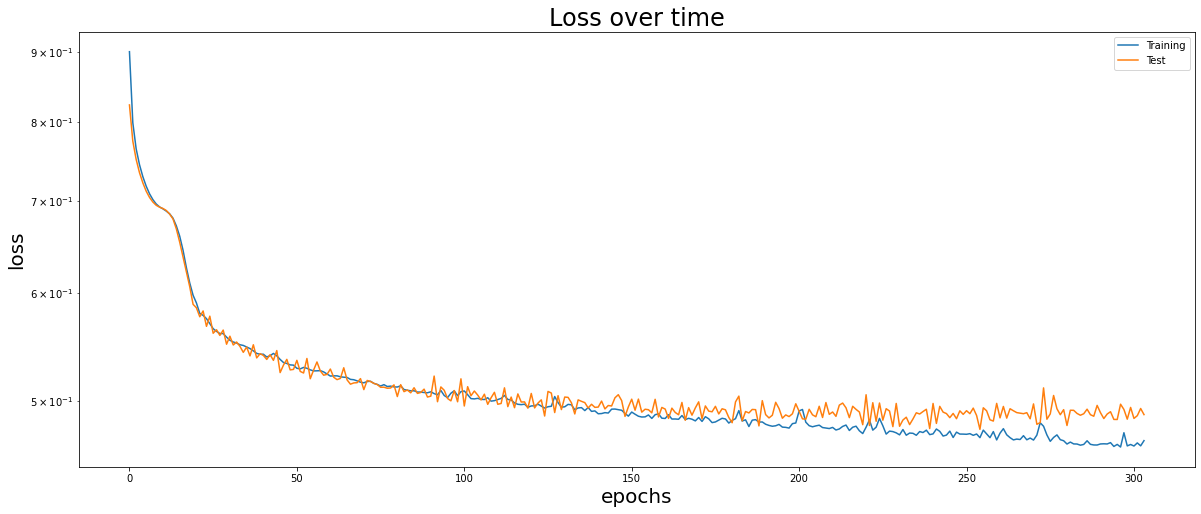

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

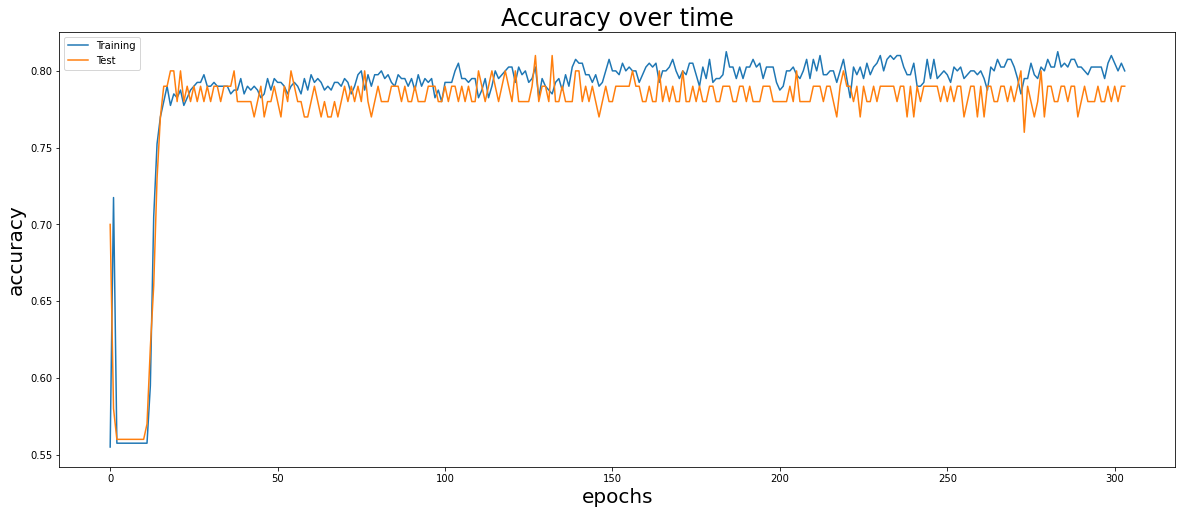

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

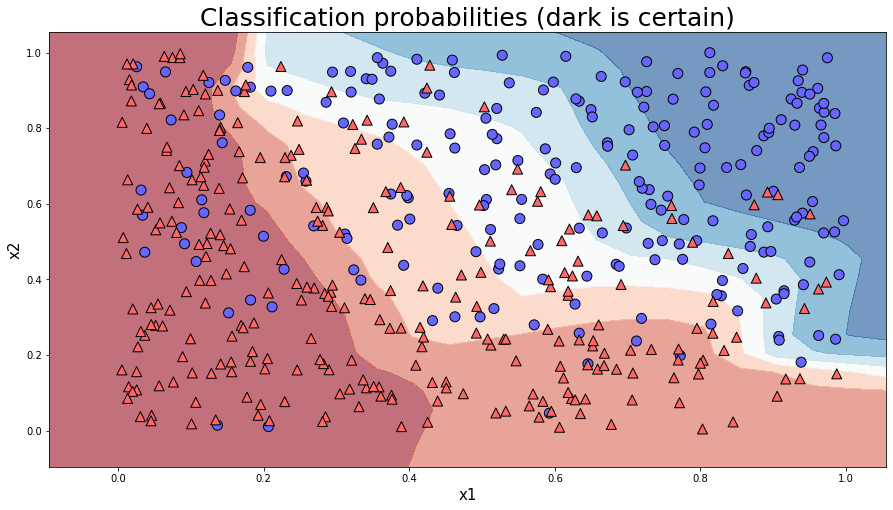

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

## L2 plus early stopping

lambda determined by manual experiment

In [ ]:
%%time 
 
EPOCHS=1000

l1 = .0
l2 = 5

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense
    
model = tf.keras.Sequential()
model.add(Dense(units=100, 
                input_dim=2, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 37.1 s, sys: 4.65 s, total: 41.7 s
Wall time: 31.6 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4884524941444397, 0.8025000095367432)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.5175449252128601, 0.7799999713897705)

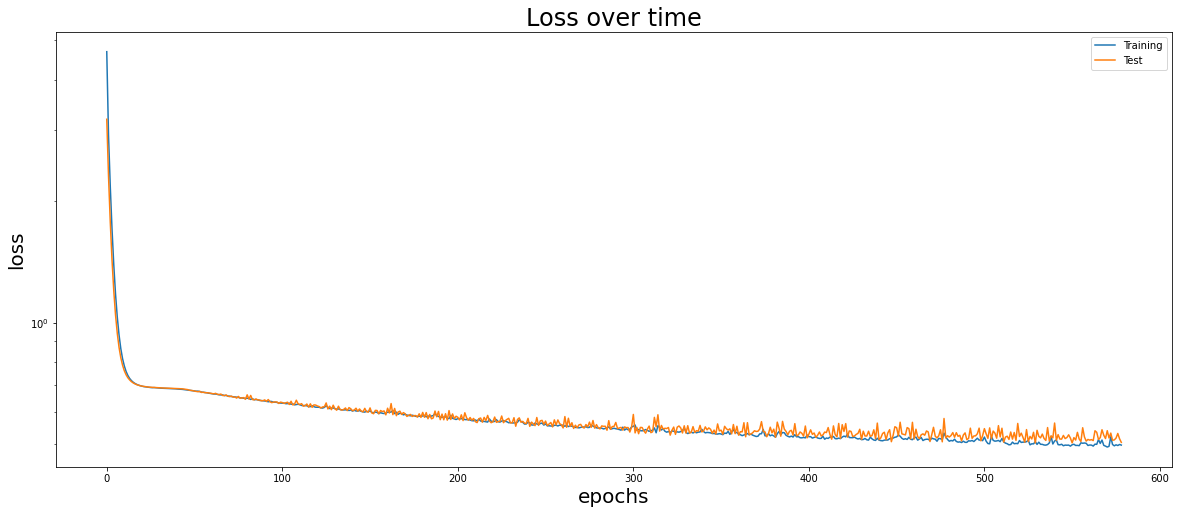

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

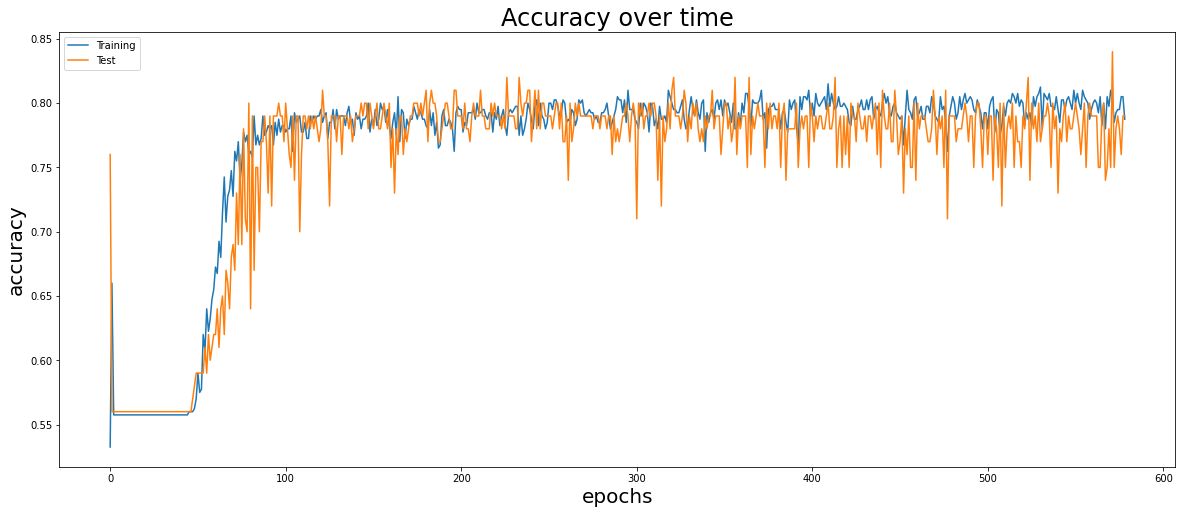

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

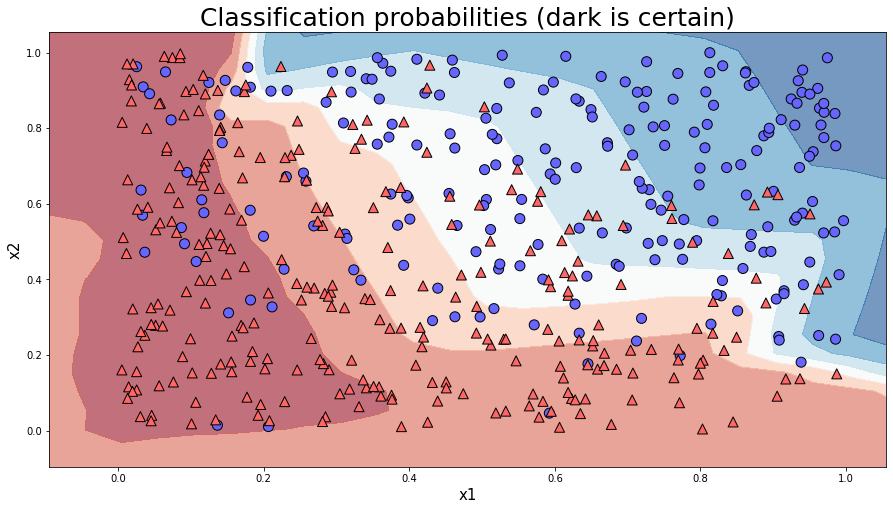

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

## L1 and L2 determined by Keras Tuner

* https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
* https://github.com/keras-team/keras-tuner
* https://keras-team.github.io/keras-tuner/

Models overly tuned using test data as corrective tend to overfit on test data and eventually don't generalize well on real world data

In [ ]:
!rm -r tuner

rm: cannot remove 'tuner': No such file or directory


In [ ]:
%%time

from tensorflow import keras

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class MyHyperModel(HyperModel):
    def __init__(self, num_layers):
        self.num_layers = num_layers

    def build(self, hp):
        model = keras.Sequential()
        l1 = hp.Float('l1', min_value=.0, max_value=.1)
        l2 = hp.Float('l2', min_value=.0, max_value=10.)

        model.add(Dense(units=100, 
                input_dim=2, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))

        for i in range(self.num_layers - 1):
          model.add(Dense(units=100, 
                  activation='relu',
                  activity_regularizer=l1_l2(l1=l1, l2=l2)))
        
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy'])
        return model


hypermodel = MyHyperModel(num_layers=3)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner',
    project_name='binary')

tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test),
             verbose=0
             )

INFO:tensorflow:Oracle triggered exit
CPU times: user 1min 26s, sys: 10 s, total: 1min 36s
Wall time: 1min 9s


In [ ]:
tuner.results_summary()

In [ ]:
%%time 

model = tuner.get_best_models(num_models=1)[0]

EPOCHS=1000

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 25.8 s, sys: 3.07 s, total: 28.8 s
Wall time: 21 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.48767372965812683, 0.8100000023841858)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.5213316679000854, 0.7900000214576721)

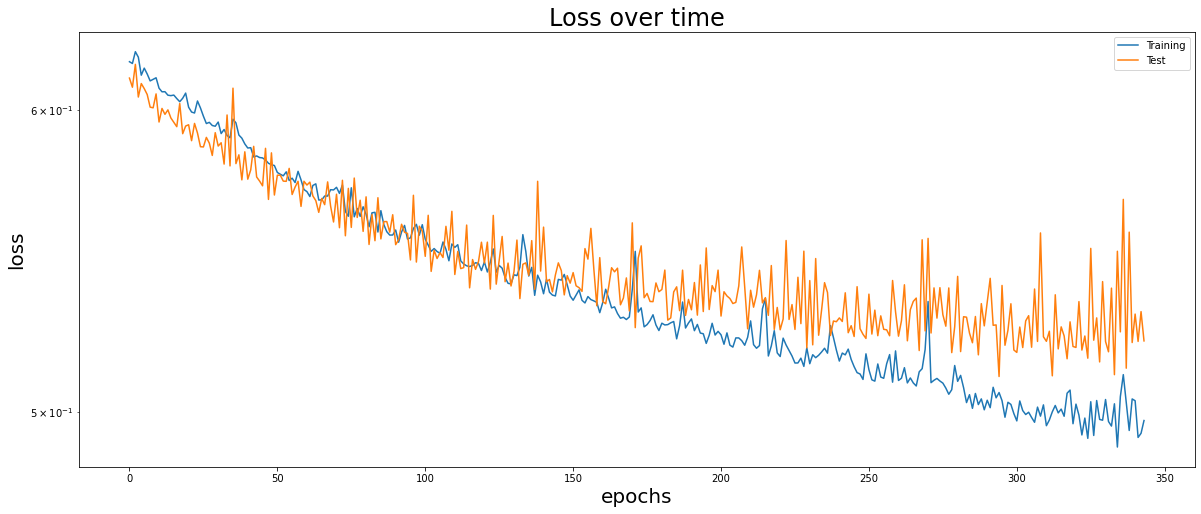

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

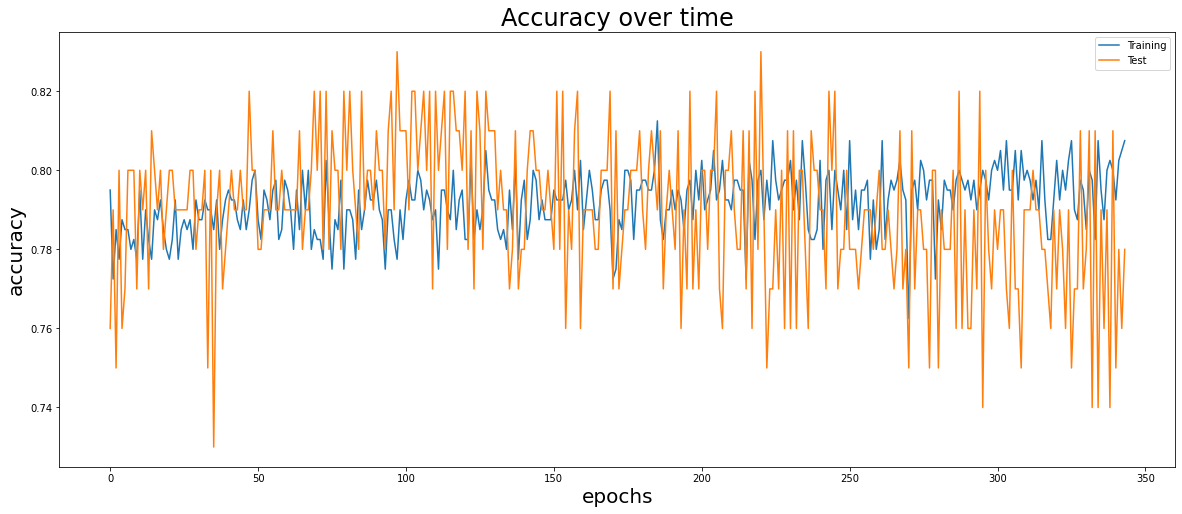

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

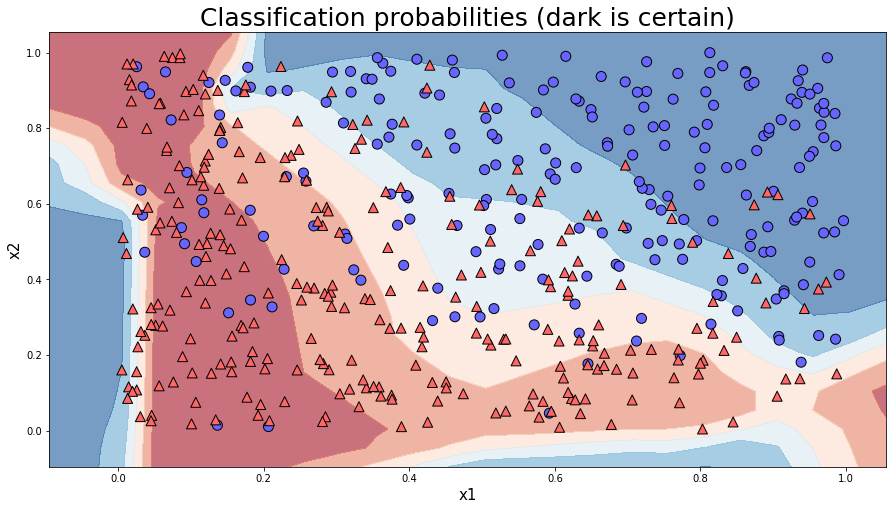

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach V: Dropout and Batch Normalization

***intuition: train a set of smaller neural networks and combine them again in an ensemble, additionally normalize data in between layers***

might still be the gold standard in combination with batch normalization and early stopping

In [ ]:
%%time 
 
EPOCHS=1000    

dropout = 0.5

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 10.7 s, sys: 895 ms, total: 11.6 s
Wall time: 9.05 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4493703842163086, 0.7875000238418579)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.45370733737945557, 0.7900000214576721)

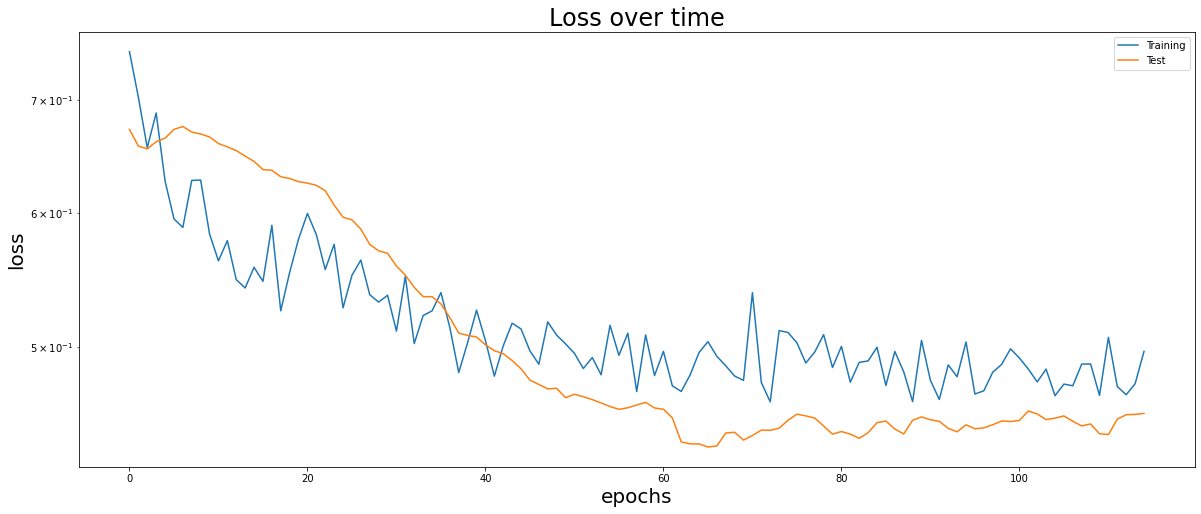

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

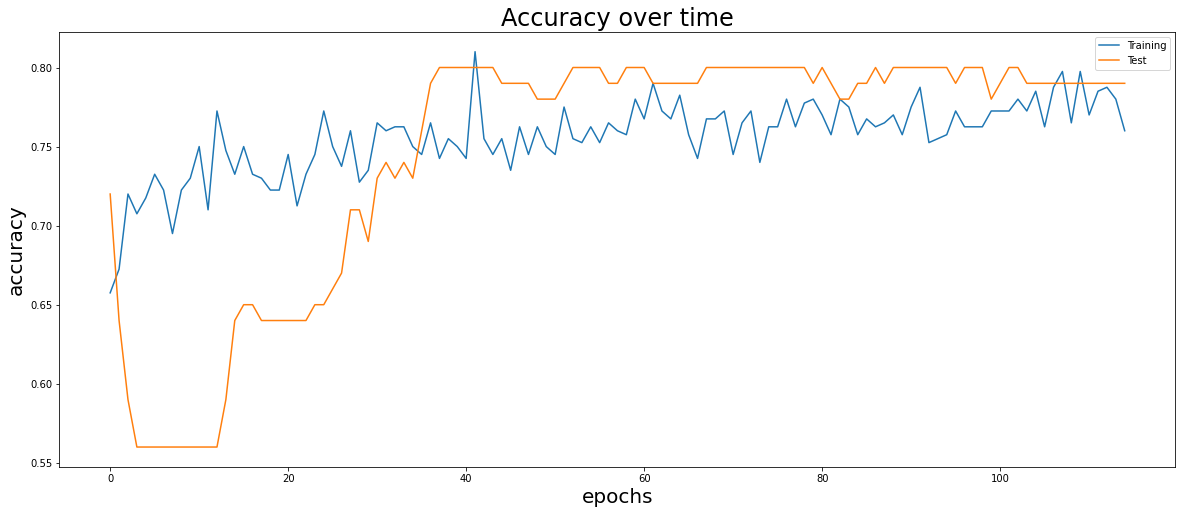

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

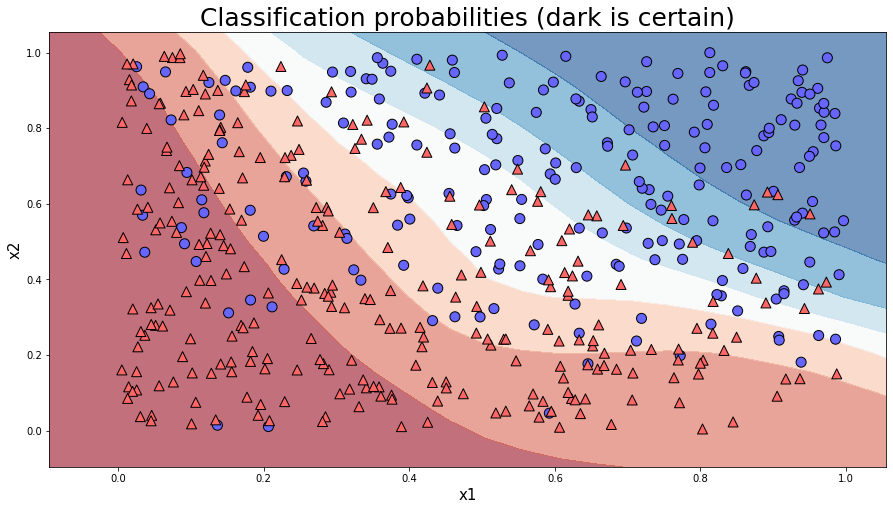

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach VI: Self-Normalizing Neural Networks 

***intuition: like dropout, but normalization is done as part of the activation function***

Self-Normalizing Neural Networks (https://arxiv.org/abs/1706.02515)
* https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu
* https://www.tensorflow.org/api_docs/python/tf/keras/initializers/lecun_normal
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AlphaDropout  

https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9

In [ ]:
%%time 
 
EPOCHS=1000    

dropout = 0.3

random_seed = 42

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense, AlphaDropout
    
model = tf.keras.Sequential()

model.add(Dense(units=100, input_dim=2, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
model.add(AlphaDropout(dropout))

model.add(Dense(units=100, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
model.add(AlphaDropout(dropout))

model.add(Dense(units=100, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
model.add(AlphaDropout(dropout))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 100
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 17.6 s, sys: 1.68 s, total: 19.3 s
Wall time: 15.2 s


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.744596540927887, 0.7799999713897705)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4769769608974457, 0.7799999713897705)

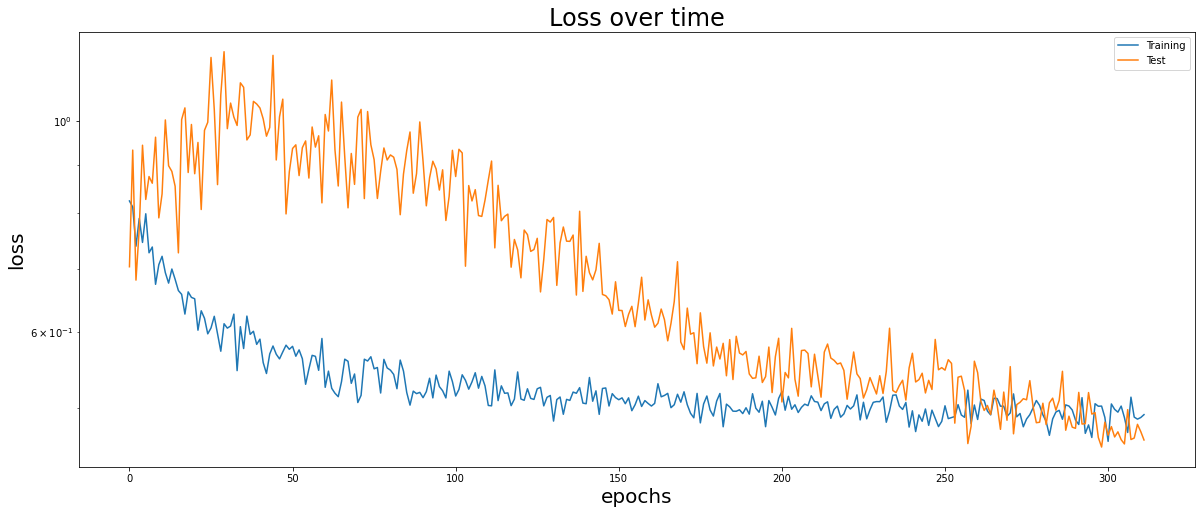

In [ ]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

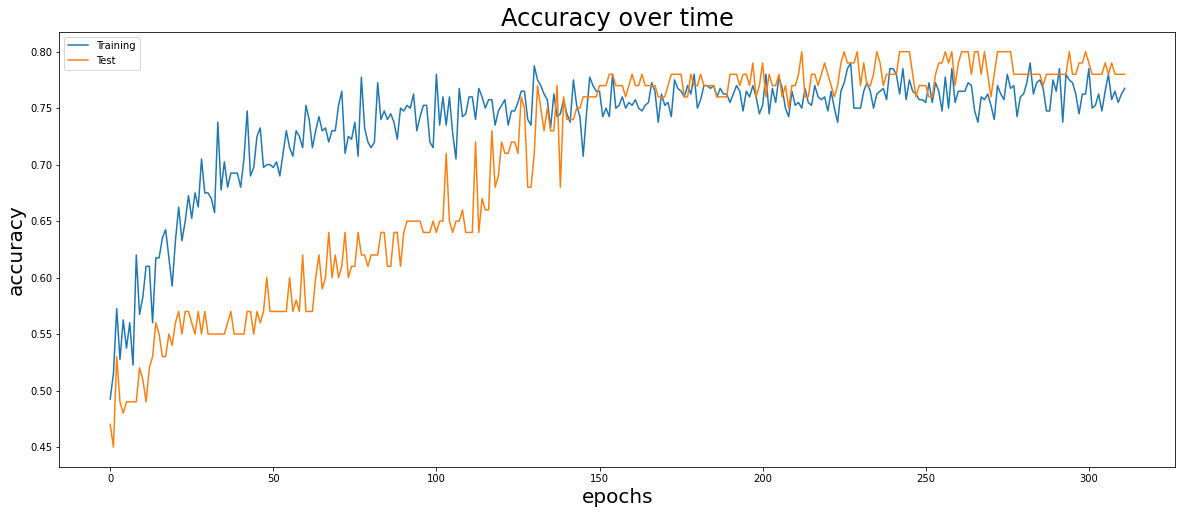

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

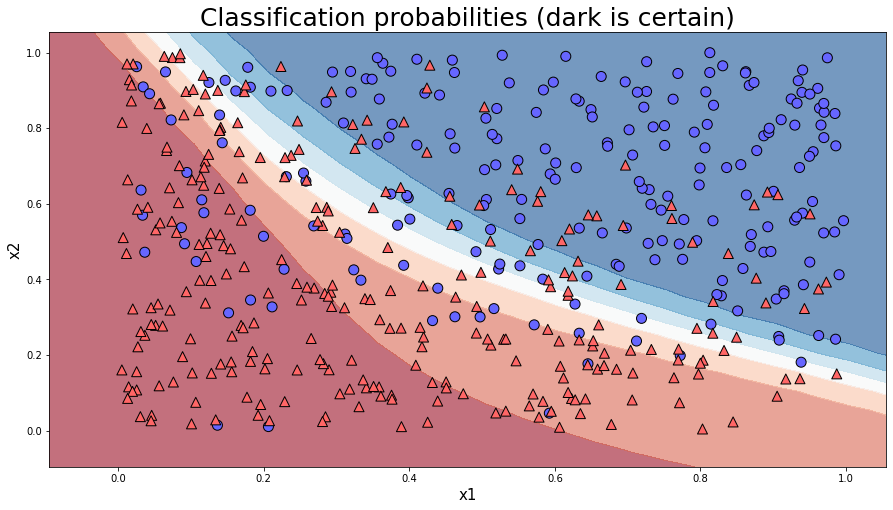

In [ ]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");